In [5]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp

from scipy.optimize import differential_evolution

# General imports
import os
import json
import numpy as np
from datetime import datetime


# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
#from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, Sampler, Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_algorithms import VQD
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes

aer_sim = AerSimulator(method='statevector')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)


# custom module
from susy_qm import calculate_Hamiltonian, create_vqe_plots

In [6]:
#potential = 'AHO'
#potential = 'AHO'
potential = 'DW'
cut_off = 16
tol = 1e-6

In [7]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [8]:
num_qubits

5

In [9]:
ansatz = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=1)

In [10]:
k=5
betas=[2 for i in range(k)]

In [18]:
counts = []
values = []
steps = []


def callback(eval_count, params, value, meta, step):
    
    fidelity_value = fidelity(params)
    print(f"Iteration {eval_count}: Fidelity = {fidelity_value}")
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [12]:
from qiskit.primitives import StatevectorEstimator, StatevectorSampler

In [19]:
backend=aer_sim
estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

C:\Users\Johnk\AppData\Local\Temp\ipykernel_16304\2266165187.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\Johnk\AppData\Local\Temp\ipykernel_16304\2266165187.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [20]:
vqd = VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-4), k=k, betas=betas, callback=callback)
result = vqd.compute_eigenvalues(operator=hamiltonian)
vqd_values = result.eigenvalues

TypeError: 'ComputeUncompute' object is not callable

In [82]:
import matplotlib.pyplot as plt
import copy

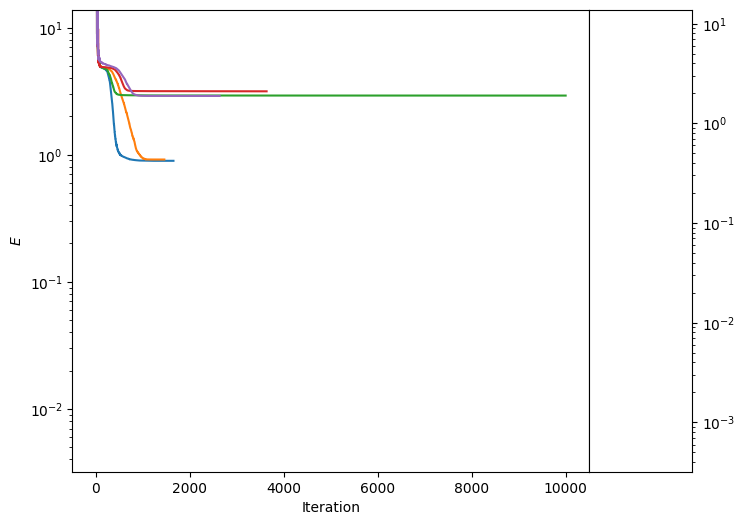

In [94]:
counts1=copy.deepcopy(counts)
values1=copy.deepcopy(values)
steps1=copy.deepcopy(steps)
k1=copy.deepcopy(k)
betas1=copy.deepcopy(betas)
result1=copy.deepcopy(result)


fig = plt.figure() 
fig.set_figheight(6)
fig.set_figwidth(8)
gs = fig.add_gridspec(1,2,wspace=0,width_ratios=[5,1])

(ax1, ax2) = gs.subplots(sharey=False)

counts1=np.asarray(counts1)
steps1=np.asarray(steps1)
values1=np.asarray(values1)
for i in range(1,k+1):
    _counts1=counts1[np.where(steps1==i)]
    _values1=values1[np.where(steps1==i)]
    ax1.plot(_counts1,_values1,label=r'$E_{{{}}}$'.format(i))
ax1.set_xlabel(r'Iteration')
ax1.set_ylabel(r'$E$')
ax1.set_ylim(3.2*1E-3,13.8)
ax1.set_yscale('log')
#plt.legend(loc='upper right')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#for i,e in enumerate(ens):
#    ax2.axhline(e, color=colors[i%len(colors)])
ax2.set_xticks([])
ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position("right")
#ax2.yaxis.set_ticks([ens[0],ens[1],ens[3],ens[5]], labels=[r"$1$",r"$2$",r"$2$",r"$2$"])
ax2.set_ylim(3.2*1E-4,13.8)

plt.show()
#plt.savefig('Plots/aho_vqd.pdf')